In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available! Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available! Using CPU.")

CUDA is available! Using GPU.


## Loading the CNN model
### We download the weights of the pretrained inception-resnet-V2 here from github

In [4]:
from __future__ import print_function, division, absolute_import
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import os
import sys

__all__ = ['InceptionResNetV2', 'inceptionresnetv2']

pretrained_settings = {
    'inceptionresnetv2': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1000
        },
        'imagenet+background': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1001
        }
    }
}


class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=False) # verify bias false
        self.bn = nn.BatchNorm2d(out_planes,
                                 eps=0.001, # value found in tensorflow
                                 momentum=0.1, # default pytorch value
                                 affine=True)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Mixed_5b(nn.Module):

    def __init__(self):
        super(Mixed_5b, self).__init__()

        self.branch0 = BasicConv2d(192, 96, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(192, 48, kernel_size=1, stride=1),
            BasicConv2d(48, 64, kernel_size=5, stride=1, padding=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(192, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=1, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(192, 64, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Block35(nn.Module):

    def __init__(self, scale=1.0):
        super(Block35, self).__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(320, 32, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(320, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(320, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 48, kernel_size=3, stride=1, padding=1),
            BasicConv2d(48, 64, kernel_size=3, stride=1, padding=1)
        )

        self.conv2d = nn.Conv2d(128, 320, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Mixed_6a(nn.Module):

    def __init__(self):
        super(Mixed_6a, self).__init__()

        self.branch0 = BasicConv2d(320, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(320, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Block17(nn.Module):

    def __init__(self, scale=1.0):
        super(Block17, self).__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(1088, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1088, 128, kernel_size=1, stride=1),
            BasicConv2d(128, 160, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(160, 192, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.conv2d = nn.Conv2d(384, 1088, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Mixed_7a(nn.Module):

    def __init__(self):
        super(Mixed_7a, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 288, kernel_size=3, stride=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 288, kernel_size=3, stride=1, padding=1),
            BasicConv2d(288, 320, kernel_size=3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Block8(nn.Module):

    def __init__(self, scale=1.0, noReLU=False):
        super(Block8, self).__init__()

        self.scale = scale
        self.noReLU = noReLU

        self.branch0 = BasicConv2d(2080, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(2080, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 224, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(224, 256, kernel_size=(3,1), stride=1, padding=(1,0))
        )

        self.conv2d = nn.Conv2d(448, 2080, kernel_size=1, stride=1)
        if not self.noReLU:
            self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = self.relu(out)
        return out


class InceptionResNetV2(nn.Module):

    def __init__(self, num_classes=1001):
        super(InceptionResNetV2, self).__init__()
        # Special attributs
        self.input_space = None
        self.input_size = (299, 299, 3)
        self.mean = None
        self.std = None
        # Modules
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)
        self.maxpool_5a = nn.MaxPool2d(3, stride=2)
        self.mixed_5b = Mixed_5b()
        self.repeat = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17)
        )
        self.mixed_6a = Mixed_6a()
        self.repeat_1 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10)
        )
        self.mixed_7a = Mixed_7a()
        self.repeat_2 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20)
        )
        self.block8 = Block8(noReLU=True)
        self.conv2d_7b = BasicConv2d(2080, 1536, kernel_size=1, stride=1)
        self.avgpool_1a = nn.AvgPool2d(8, count_include_pad=False)
        self.last_linear = nn.Linear(1536, num_classes)

    def features(self, input):
        x = self.conv2d_1a(input)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.maxpool_5a(x)
        x = self.mixed_5b(x)
        x = self.repeat(x)
        x = self.mixed_6a(x)
        x = self.repeat_1(x)
        x = self.mixed_7a(x)
        x = self.repeat_2(x)
        x = self.block8(x)
        x = self.conv2d_7b(x)
        return x

    def logits(self, features):
        x = self.avgpool_1a(features)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x

def inceptionresnetv2(num_classes=1000, pretrained='imagenet'):
    r"""InceptionResNetV2 model architecture from the
    `"InceptionV4, Inception-ResNet..." <https://arxiv.org/abs/1602.07261>`_ paper.
    """
    if pretrained:
        settings = pretrained_settings['inceptionresnetv2'][pretrained]
        assert num_classes == settings['num_classes'], \
            "num_classes should be {}, but is {}".format(settings['num_classes'], num_classes)

        # both 'imagenet'&'imagenet+background' are loaded from same parameters
        model = InceptionResNetV2(num_classes=1001)
        model.load_state_dict(model_zoo.load_url(settings['url']))

        if pretrained == 'imagenet':
            new_last_linear = nn.Linear(1536, 1000)
            new_last_linear.weight.data = model.last_linear.weight.data[1:]
            new_last_linear.bias.data = model.last_linear.bias.data[1:]
            model.last_linear = new_last_linear

        model.input_space = settings['input_space']
        model.input_size = settings['input_size']
        model.input_range = settings['input_range']

        model.mean = settings['mean']
        model.std = settings['std']
    else:
        model = InceptionResNetV2(num_classes=num_classes)
    return model
model = inceptionresnetv2(num_classes=1000, pretrained='imagenet')
    

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /root/.cache/torch/hub/checkpoints/inceptionresnetv2-520b38e4.pth
100%|██████████| 213M/213M [10:28<00:00, 356kB/s]


### Modifying the classification layer for our purposes and freezing other weights

In [5]:
model.last_linear = nn.Linear(1536,512)
nn.init.xavier_uniform_(model.last_linear.weight)
nn.init.constant_(model.last_linear.bias, 0)
for param in model.parameters():
    param.requires_grad = False
for param in model.last_linear.parameters():
    param.requires_grad = True
def list_parameters(model):
    print("Parameter List:")
    for name, param in model.named_parameters():
        print(f"Name: {name}, Requires Grad: {param.requires_grad}")
list_parameters(model)


Parameter List:
Name: conv2d_1a.conv.weight, Requires Grad: False
Name: conv2d_1a.bn.weight, Requires Grad: False
Name: conv2d_1a.bn.bias, Requires Grad: False
Name: conv2d_2a.conv.weight, Requires Grad: False
Name: conv2d_2a.bn.weight, Requires Grad: False
Name: conv2d_2a.bn.bias, Requires Grad: False
Name: conv2d_2b.conv.weight, Requires Grad: False
Name: conv2d_2b.bn.weight, Requires Grad: False
Name: conv2d_2b.bn.bias, Requires Grad: False
Name: conv2d_3b.conv.weight, Requires Grad: False
Name: conv2d_3b.bn.weight, Requires Grad: False
Name: conv2d_3b.bn.bias, Requires Grad: False
Name: conv2d_4a.conv.weight, Requires Grad: False
Name: conv2d_4a.bn.weight, Requires Grad: False
Name: conv2d_4a.bn.bias, Requires Grad: False
Name: mixed_5b.branch0.conv.weight, Requires Grad: False
Name: mixed_5b.branch0.bn.weight, Requires Grad: False
Name: mixed_5b.branch0.bn.bias, Requires Grad: False
Name: mixed_5b.branch1.0.conv.weight, Requires Grad: False
Name: mixed_5b.branch1.0.bn.weight, Requ

## Dataloader
### We create a custom dataloader that batchifies the input and calculates the one hot vector for training

In [6]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
from torch.utils.data import dataset
from torch import nn, Tensor

import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
from torch.utils.data import dataset

df = pd.read_csv('/kaggle/input/deep-learning-term-project/custom_captions_dataset/train.csv')
captions = df['caption']
train_iter = iter(captions)

tokenizer = get_tokenizer('basic_english')

# Define the vocabulary with the special token '<pad>'
specials = ['<unk>', '<pad>','<start>','<eos>']
vocab = build_vocab_from_iterator(map(tokenizer, train_iter),min_freq=1, specials=specials)
vocab.set_default_index(vocab['<unk>'])
max_len = max(len(tokenizer(item)) for item in captions)
max_len = max(max_len,512)
print(max_len)
def data_process(raw_text_iter, vocab):
    """Converts raw text into a flat Tensor."""
    data = []
    for item in raw_text_iter:
        tokens = [vocab[token] for token in tokenizer(item)]
        # Pad the tokens to ensure uniform length
        tokens = tokens + [vocab['<eos>']]
        padded_tokens = tokens + [vocab['<pad>']] * (max_len - len(tokens))
        padded_tokens = padded_tokens[:51]
        caption_length = 50
        clipped_caption = torch.as_tensor(padded_tokens[:caption_length])
        one_hot_tensor = torch.zeros(50, len(vocab))
        one_hot_tensor[torch.arange(50), clipped_caption] = 1
        data.append((one_hot_tensor, torch.tensor(padded_tokens, dtype=torch.long)))
    return data


512


In [7]:
train_captions = pd.read_csv('/kaggle/input/deep-learning-term-project/custom_captions_dataset/train.csv')['caption']
train_iter = iter(train_captions)
test_captions = pd.read_csv('/kaggle/input/deep-learning-term-project/custom_captions_dataset/test.csv')['caption']
test_iter = iter(test_captions)
val_captions = pd.read_csv('/kaggle/input/deep-learning-term-project/custom_captions_dataset/val.csv')['caption']
val_iter = iter(val_captions)
train_data = data_process(train_iter,vocab)
val_data = data_process(val_iter,vocab)
test_data = data_process(test_iter,vocab)
print(test_data[0])
#print(train_data)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]), tensor([  6,  35,  50,  16, 859,   8,   4, 157,  13,  29,  10,  20,   5,  12,
          7,  41, 116,  13,  29,  10,   4,  50,   5,  12,   7,   6,  59,  13,
         29,  10,   4,  50,  16, 109, 162,   8,  20,   5,   3,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1]))


In [8]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, image_folder, captions, csv_file, transform=None):
        self.image_folder = image_folder
        self.captions = captions
        self.transform = transform
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.data.iloc[idx, 1])
        image = Image.open(img_name).convert("RGB")
        caption = self.captions[idx]
        #print("Dataloader: caption:",caption)
        if self.transform:
            image = self.transform(image)
        
        return image, caption


In [9]:
import os
from PIL import Image
import pandas as pd

from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_folder = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/train'
csv_file = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/train.csv'
train_dataset = CustomDataset(image_folder, train_data, csv_file, transform=transform)

image_folder = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/test'
csv_file = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/test.csv'
test_dataset = CustomDataset(image_folder, test_data, csv_file, transform=transform)

image_folder = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/val'
csv_file = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/val.csv'
validation_dataset = CustomDataset(image_folder, val_data, csv_file, transform=transform)

batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)


### Checking the dataloader

Sample 1:


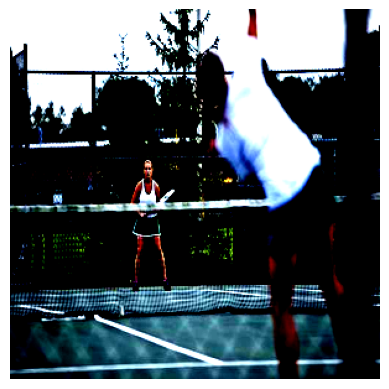

two women are playing tennis on a court with a net . they are wearing green skirts and a white shirt . there are trees behind the court .


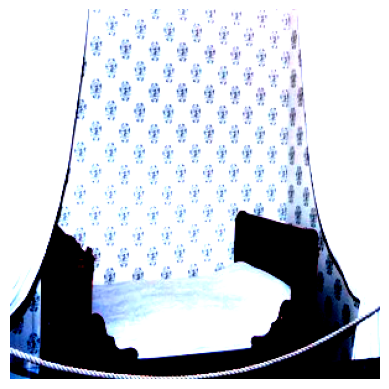

a darkly stained bench with a white pillow sits on display in a room . there are white curtains on either side of the bench . behind the bench there is a wall with a white wallpaper with gray designs on it . there is a white rope in front of


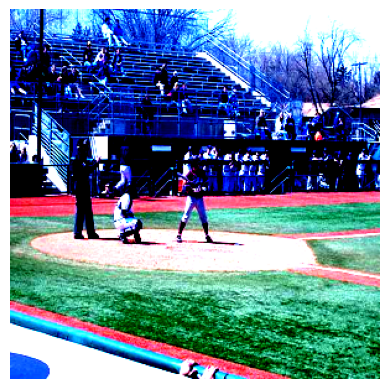

a bunch of people are at a minor baseball game . a player is getting ready to get ready to bat . there are not many people in the stadium . the trees have no leaves but the sky looks very clear .


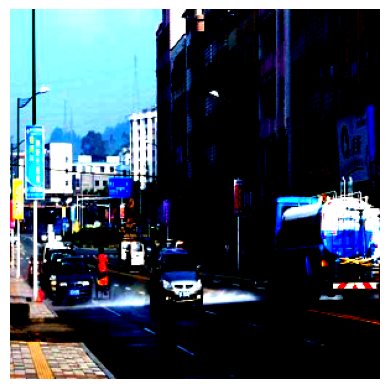

some cars are in traffic in the street . the street appears to be wet and a fire hydrant is going off . there is one car that has just driven across the splashes and a truck is getting ready to . the truck is white and blue . there are


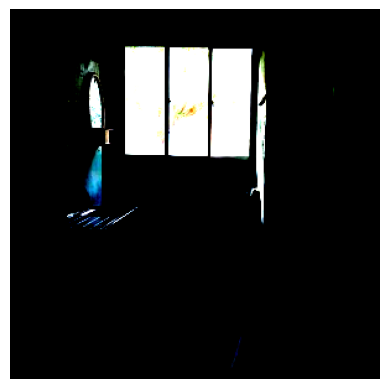

an empty room has debris on the ground . there is no furniture in this room . there is a long shelf on the wall , and some other decoration hanging above the shelf . there is a triple window at the end of the room , with no curtains .


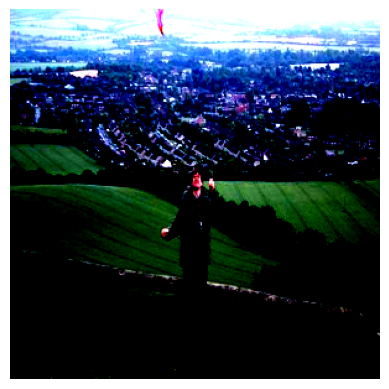

the man is standing in the grass flying a kite . there is a long trail behind the man . the kite is red . the man is wearing a hunter green jacket . the jacket has a hood on it . the green fields behind the man are mowed nicely


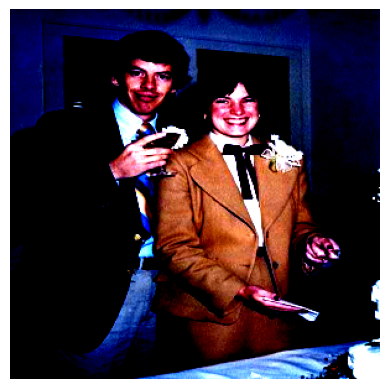

the image is of a man and a woman from the 80 ' s cutting a wedding cake . the man is holding a champagne glass . both the man and woman have brown hair . the man is wearing a black sports jacket , with a blue shirt and a


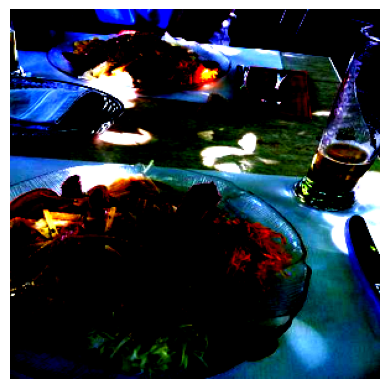

a table has two plates of food on it . the food includes vegetables , cut up sausage , french fries and pickle . the plates are both clear and round . there is a metal plate on the center of the table with a gray towel in it . a


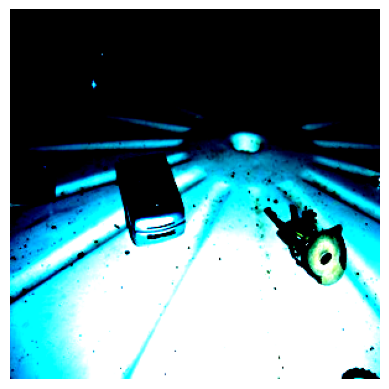

personal items scattered across a white surface . there is a silver electronic device sitting among the scattered personal items . there is a person with black shoes standing near the personal items . there is a design in the floor with the personal items on top of it . there


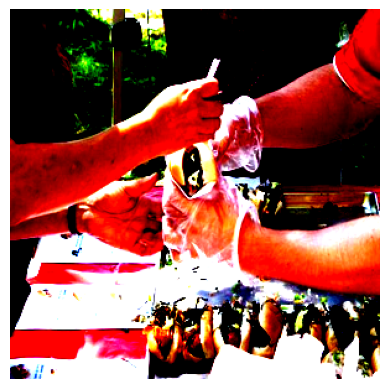

there is a tray of hot dogs sitting on top of a table . the table is red and has white papers on top of it . there are peoples hands above the table holding a hot dog .


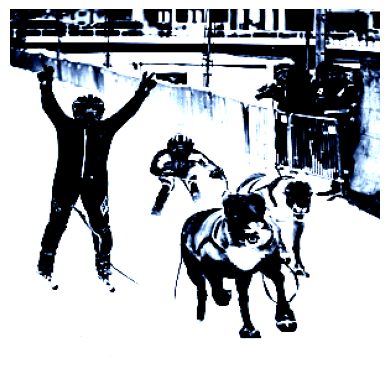

there is a man holding his arms up as he is being pulled by a miniature pony . there is a second man being pulled by a pony beside the man with his arms up . there is a small group of people watching on the sidelines . there is a


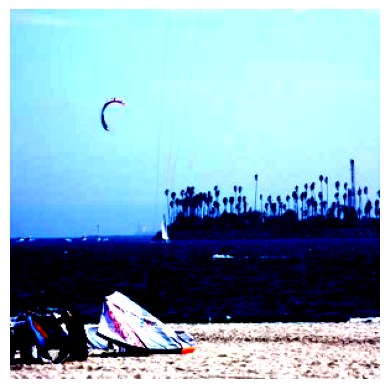

a man in black clothes , and a black helmet is walking in the sand on the beach on a gray , cloudy , day . the man is holding a surfboard , and some type of frame and is walking away from the shore . on the right of the


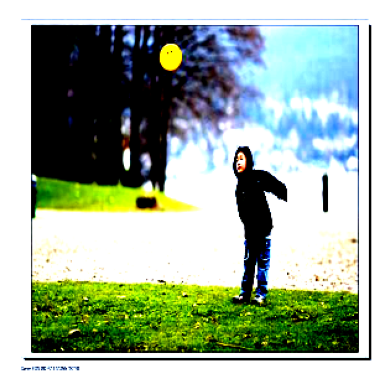

a little boy is wearing a black jacket and blue jeans . he is looking up a the frisbee . the frisbee has smiling face on it . the frisbee is yellow . the boy is standing on the grass . the grass is littered with some dried leaves . behind


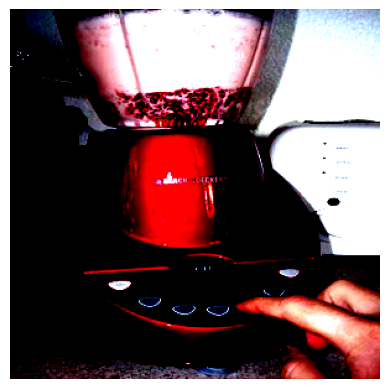

a woman with red fingernail polish is using a red black and decker blender . it appears as if she is making a milk shake . in the blender there is a milk like substance , and a red fruit like strawberries . the woman is pushing the fifth button from


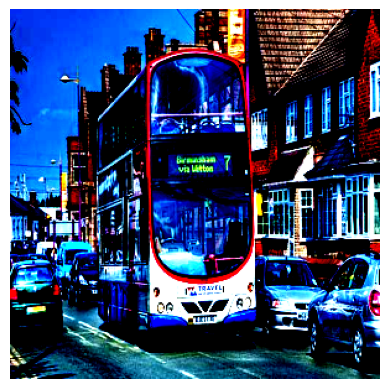

a white , red , and blue double deck bus is driving along a narrow one lane street . cars are parked along both sides of the street . the bus has a birmingham via witton and the number 7 digital sign in the middle of the two decks . the


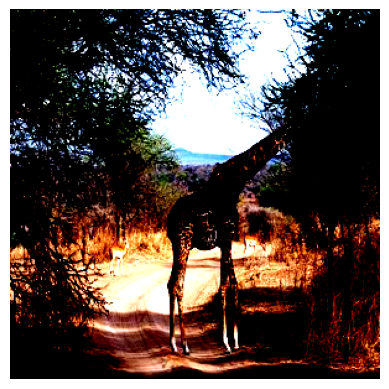

the giraffe is standing in the center of the dirt road . the giraffe is eating from a tree . the giraffe ' s belly is rounded . behind the giraffe is a small brown deer walking towards the road .


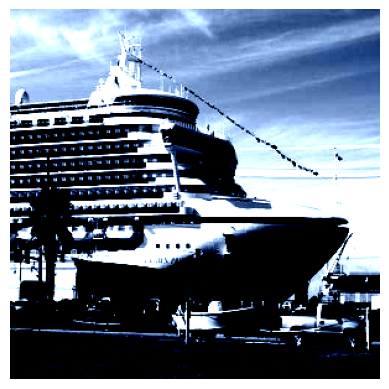

a very large cruise ship is parked ready to voyage . there is one lone palm tree growing from the grassy area beside the cruise ship . many levels of the cruise ship can be seen . a long line on flags is hanging from the ship to a white pole


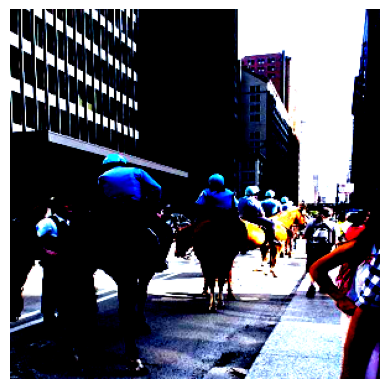

there are people riding on horses . there are three horses . the horse in the back is dark brown . the people riding horses are wearing blue . the helmets are light blue in color .


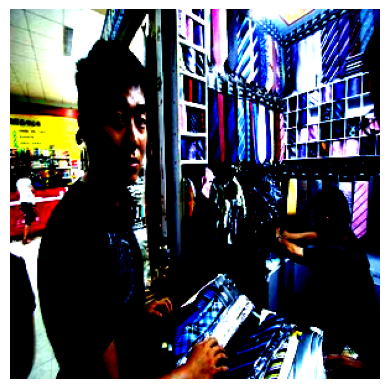

a man is wearing a black shirt with sunglasses around his neck . he is standing in front of a counter that has ties on it . there is a man sitting behind the counter in front of ties that are hung on the wall .


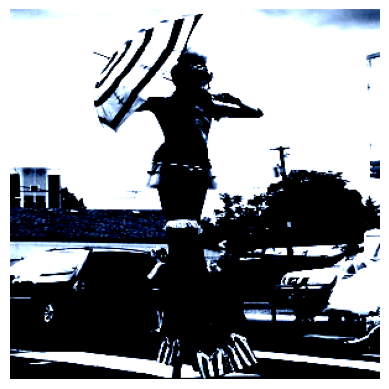

a woman is walking on stilts on the side of a street . the woman is wearing a tall hat with white feathers at the very top of the hat . she is also carrying a black and white striped umbrella . the cuffs of her pants also have black and


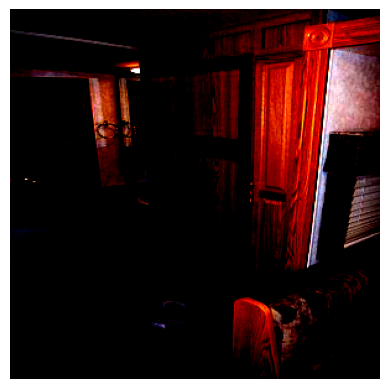

this picture is taken inside of a room . the floor has different color tiles on it . a brown trash can is sitting on the floor with a white bag in it . the door to the room is wooden and brown with a gold handle on it . there


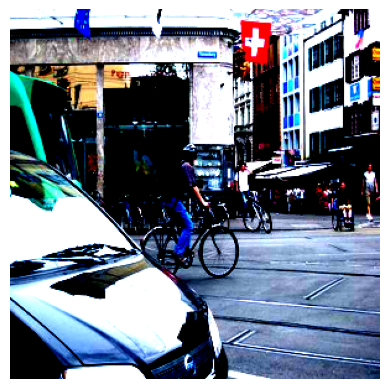

this photo is of a large urbanized area . there are building against the sidewalks , all with windows , some with shutters . awnings also line the sidewalk and underneath of them it ' s crowded . a green bus and a black car can be seen driving down the


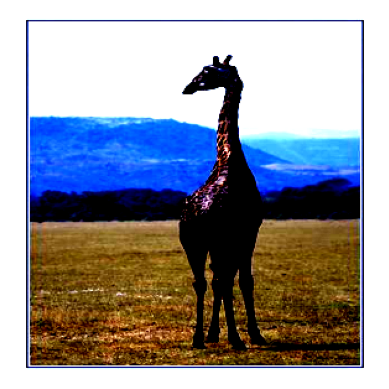

a giraffe is in the field . the giraffe has a long neck . the spots are very dark brown in color . the mountains can be seen in the background .


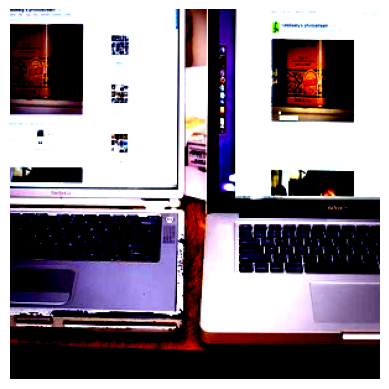

two grey laptops sit side by side on a wood table . both are open and their screens are in an upright position . both screens show part of the same scene . a picture in the middle of the screens is gold with a black scroll design at the bottom


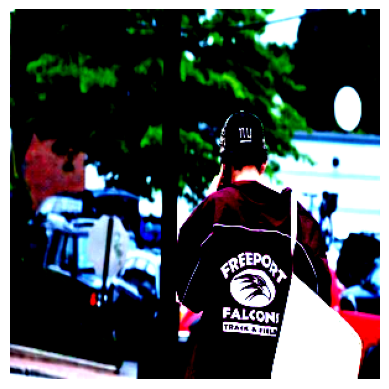

there is a person wearing a red jacket and a black cap . the person is talking on the cell phone . there are cars parked along the street . there is a large tree next to the cars .


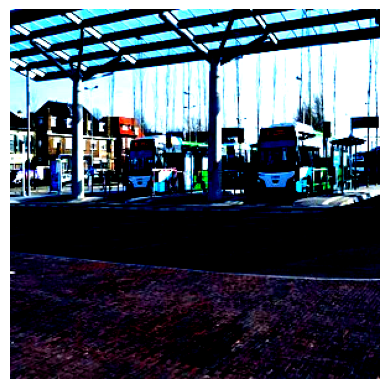

this photo was taken outdoors at a bus station . it is day time in the picture . there are two busses parked at the station . there is a metal structure above the busses . on the right are an array of houses . the street is black and the


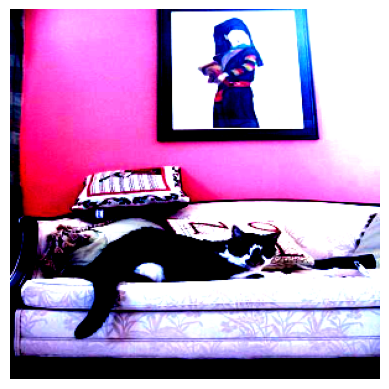

the cat is laying on the couch . their pillows behind the cat . the couch is cream color . the couch has print of flowers on it . there is a picture above the couch . the cat ' s tail is hanging off the side of the couch .


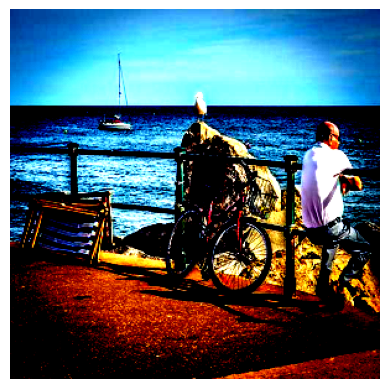

a bald man is sitting on a green , metal fence . beside him is his red bike . outside the fence is a big rock , with a white bird on it . further down the sea is a small boat .


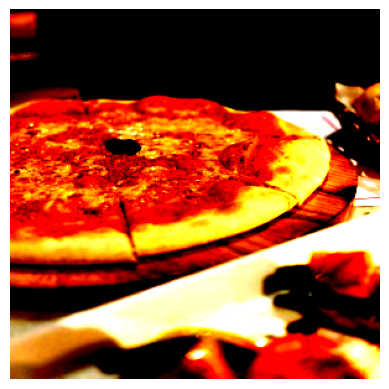

a pizza pie sits on a table , ready to eat . the pie has been sliced and is on a serving circle . there is no topping over than cheese and a single green leaf . a dish with food is next to the pie .


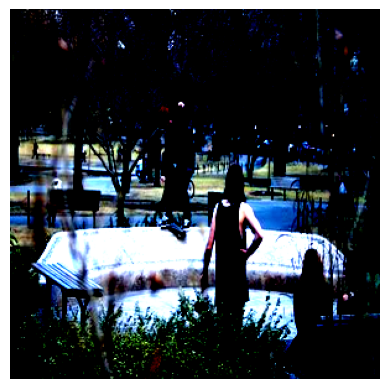

the park has trees sporadically placed . the trees do not have leaves . the bushes , however are still green with leaves . there are wooden benches in the park as well as a large concrete structure . there are people sitting on the bench in the forefront of the


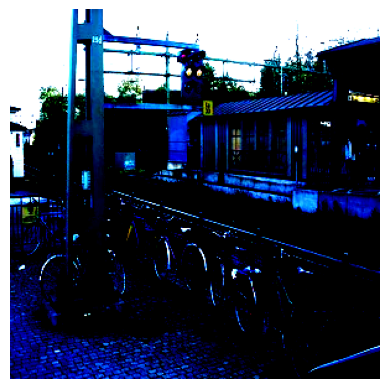

there are a lot of bikes parked next to a gate . the gate is black and iron . there are train tracks next to the gate . the station can be seen there is a big green pole next to the bikes .


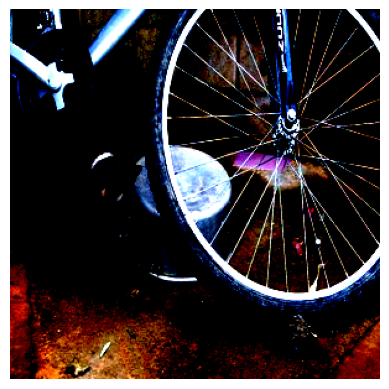

there is a cat in the picture standing underneath a bicycle . the cat is a tiger cat with brown and black stripes . it looks like it has a white collar on . it seems to be stalking a dead bird , which is underneath the front tire . the



In [10]:
import matplotlib.pyplot as plt
import numpy as np
def generate_text_from_tensor(tensor, vocab):
    """Converts a tensor back into text."""
    # Iterate over each token in the tensor
    tokens = [vocab.lookup_token(token) for token in tensor]
    # Remove '<pad>' tokens and '<eos>' tokens (if any)
    tokens = [token for token in tokens if token != '<pad>' and token != '<eos>']
    # Concatenate the tokens into a single string
    text = ' '.join(tokens)
    return text
num_samples = 1
for i, (images, captions) in enumerate(train_data_loader):
    if i >= num_samples:
        break
    #print(captions[1])
    print(f"Sample {i + 1}:")
    for image, caption in zip(images, captions[1]):
        # Convert the image tensor to a numpy array
        image_np = image.permute(1, 2, 0).numpy()  # Change tensor shape from (C, H, W) to (H, W, C)
        
        # Display the image
        plt.imshow(image_np)
        plt.axis('off')
        plt.show()
        print(generate_text_from_tensor(caption,vocab))
    print()

# for i, (images, captions) in enumerate(test_data_loader):
#     if i >= num_samples:
#         break
    
#     print(f"Sample {i + 1}:")
#     for image, caption in zip(images, captions):
#         # Convert the image tensor to a numpy array
#         image_np = image.permute(1, 2, 0).numpy()  # Change tensor shape from (C, H, W) to (H, W, C)
        
#         # Display the image
#         plt.imshow(image_np)
#         plt.axis('off')
#         plt.show()
#         print(generate_text_from_tensor(caption,vocab))
#     print()
    
# for i, (images, captions) in enumerate(validation_data_loader):
#     if i >= num_samples:
#         break
    
#     print(f"Sample {i + 1}:")
#     for image, caption in zip(images, captions):
#         # Convert the image tensor to a numpy array
#         image_np = image.permute(1, 2, 0).numpy()  # Change tensor shape from (C, H, W) to (H, W, C)
        
#         # Display the image
#         plt.imshow(image_np)
#         plt.axis('off')
#         plt.show()
#         print(generate_text_from_tensor(caption,vocab))
#     print()


## Captioning model
### Our captioning model passes the input through the pretrained CNN and uses a 3 layer LSTM to generate the caption autoregressively(teacher forcing used during training)

In [11]:
import torch.nn.init as init
class my_transformer(nn.Module):
    def __init__(self,n_tokens):
        super(my_transformer, self).__init__()
#         self.transformer = nn.Transformer(
#                                 d_model=512,  # Dimension of the model
#                                 nhead=8,      # Number of attention heads
#                                 num_encoder_layers=6,  # Number of encoder layers
#                                 num_decoder_layers=6,  # Number of decoder layers
#                                 dim_feedforward=2048,  # Dimension of the feedforward network
#                                 dropout=0.1,   # Dropout probability
#                                 activation='relu',  # Activation function ('relu' or 'gelu')
#                                 batch_first=True
#                             )
        self.lstm = nn.LSTM(512,512,num_layers=3,batch_first=True)
        self.encoder = nn.Linear(n_tokens,512)
        self.decoder = nn.Linear(512,n_tokens)
        self._init_weights()

    def _init_weights(self):
        # Initialize encoder and decoder weights using Xavier initialization
        init.xavier_uniform_(self.encoder.weight)
        init.xavier_uniform_(self.decoder.weight)
        
    def forward(self,src,tgt):
        #print(src.shape,output.shape,"Output shape")
        #print("output",output)
        #tgt_mask = self.transformer.generate_square_subsequent_mask(output.shape[1]).to(device)
        output = self.encoder(tgt)
        src = src.unsqueeze(1)
        #print(output.shape,src.shape)
        output = torch.cat((src,output),dim=1)
        #print(output.shape)
        output,_ = self.lstm(output)
        #print(output)
        output = self.decoder(output)
        return output

In [12]:


def tensor_to_text(tensor, vocab):
    # Apply softmax along the second dimension (n_tokens)
    softmax_output = torch.softmax(tensor, dim=1)
    
    # Get the indices of the maximum value along the second dimension
    max_indices = torch.argmax(softmax_output, dim=1)
    
    # Convert the indices to text using the provided vocabulary
    text = [vocab.lookup_token(idx.item()) for idx in max_indices]
    
    return text

# print(tensor_to_text(output.view(-1,n_tokens),vocab))

### Training the model

In [13]:
#device = 
model.to(device)
transformer_model = my_transformer(len(vocab))
transformer_model.to(device)
model.train()
transformer_model.train()
import torch
import torch.nn as nn
import torch.optim as optim

transformer_model.train()
loss_function = nn.CrossEntropyLoss(ignore_index = vocab.__getitem__('<pad>'))
print(vocab.lookup_token(vocab.__getitem__('<pad>')))

optimizer = optim.AdamW(list(transformer_model.parameters())+list(model.parameters()),  lr=1e-3)

# Number of epochs
num_epochs = 100

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    # Iterate over the dataset
    for i, (images, captions) in enumerate(train_data_loader):
        optimizer.zero_grad()
        loss=0
        embeddings = model(images.to(device))
        output = transformer_model(src=embeddings.to(device),tgt=captions[0].to(device))
        #print(output[0][0],captions[1].shape)
        output = output.view(-1, len(vocab))
        captions_flattened = captions[1].view(-1)
        loss = loss_function(output.to(device), captions_flattened.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Print average loss for the epoch
    print(tensor_to_text(output,vocab))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_data_loader)}")


<pad>
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the',

## Generating captions for evaluation

In [14]:
model.eval()
transformer_model.eval()
model.to(device)
transformer_model.to(device)
predictions = []
for i, (images, captions) in enumerate(test_data_loader):
    for image,caption in zip(images,captions[1]):
        #print(caption)
        predicted = torch.empty(0)
        #predicted = torch.cat((predicted,torch.tensor([vocab.__getitem__('<start>')])),dim=0)
        embeddings = model(image.unsqueeze(0).to(device))
        #print(embeddings)
        while(len(predicted)<50):
            one_hot_tensor = torch.zeros(len(predicted), len(vocab))
            one_hot_tensor[torch.arange(len(predicted)), predicted.type(torch.long)] = 1
            #print(embeddings.shape,one_hot_tensor.shape)
            #print(embeddings.shape,one_hot_tensor.unsqueeze(0).shape)
            output = transformer_model(src=embeddings.to(device),tgt=one_hot_tensor.unsqueeze(0).to(device))
            new_prediction = output[-1][-1]
            predicted = torch.cat((predicted,torch.tensor([torch.argmax(new_prediction)])),dim=0)
            #print(predicted)
        print("Generated: ",generate_text_from_tensor(predicted,vocab))
        print("Actual: ",generate_text_from_tensor(caption,vocab))
        predictions.append(generate_text_from_tensor(predicted,vocab))
        #break
    #break
        

Generated:  a white microwave that isn ' t plugged up . there is a crockpot sitting on top of the microwave . the microwave is sitting on a fridge and a shelf is next to it . are sitting in it that are opened and it has a white and
Actual:  a white refrigerator is against a wall in a kitchen . someone has positioned two magnets to appear as eyes on the refrigerator so the appliance appears to have a face . there are two white handles in between the magnets to appear as if they are the nose on the
Generated:  a woman is standing outside . she is wearing a black suit and a black hat . there is a white box on the counter with her left hand on the counter . can be seen behind the woman in front of an elephant . are standing on
Actual:  a man in a yellow rain coat is walking on the sidewalk . there is a woman standing next to him carrying a blue and white umbrella . there is a lady and a little boy crossing the street .
Generated:  a baseball player is standing on a baseball field . he is w

In [15]:
!pip install nltk
!pip install pycocoevalcap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 19.1 MB/s eta 0:00:00


In [16]:
import torch
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

# Initialize the evaluation tools
rouge = Rouge()
cider = Cider()
spice = Spice()

# Prepare to collect data for evaluation
results = {}
references = {}

for i, (images, captions) in enumerate(test_data_loader):
    for j, (image, caption) in enumerate(zip(images, captions[1])):
        predicted = torch.empty(0)
        embeddings = model(image.unsqueeze(0).to(device))

        while len(predicted) < 50:
            one_hot_tensor = torch.zeros(len(predicted), len(vocab))
            one_hot_tensor[torch.arange(len(predicted)), predicted.type(torch.long)] = 1
            output = transformer_model(src=embeddings.to(device), tgt=one_hot_tensor.unsqueeze(0).to(device))
            new_prediction = output[-1][-1]

            if torch.argmax(new_prediction) == vocab['<eos>']:
                break
            predicted = torch.cat((predicted, torch.tensor([torch.argmax(new_prediction)])), dim=0)

        generated_text = generate_text_from_tensor(predicted, vocab)
        actual_text = generate_text_from_tensor(caption, vocab)

        # Collect for metrics calculation
        img_id = f"{i}_{j}"  # Create a unique ID for each image
        results[img_id] = [generated_text]  # List of one string per image
        references[img_id] = [actual_text]  # List containing one string per image

# After collecting all data
_, rouge_score = rouge.compute_score(references, results)
_, cider_score = cider.compute_score(references, results)
_, spice_score = spice.compute_score(references, results)

print(f"ROUGE-L Score: {rouge_score}")
print(f"CIDEr Score: {cider_score}")
print(f"SPICE Score: {spice_score}")

# Save the model weights
weights_path = "transformer_model_weights.pth"
torch.save(transformer_model.state_dict(), weights_path)


Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.3 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classif

SPICE evaluation took: 2.698 min
ROUGE-L Score: [0.41388309 0.25696695 0.19189095 0.35580039 0.45322526 0.29650032
 0.21962196 0.19766688 0.21743357 0.28129117 0.27961918 0.3360337
 0.20776567 0.25696695 0.31432497 0.22922756 0.2558546  0.3179449
 0.31626701 0.27508455 0.31626701 0.25696695 0.27241498 0.28676964
 0.23720026 0.23720026 0.24751014 0.23720026 0.29650032 0.27673364
 0.22855953 0.35553705 0.23720026 0.29650032 0.23720026 0.27673364
 0.19022869 0.15813351 0.19442231 0.23453338 0.27673364 0.42807018
 0.25282592 0.25917343 0.22193347 0.25696695 0.31647211 0.23720026
 0.24110672 0.27673364 0.31626701 0.29250218 0.40162665 0.25696695
 0.3030303  0.40632806 0.21743357 0.21743357 0.27333831 0.4858798
 0.30290298 0.27673364 0.19766688 0.25696695 0.30360846 0.19766688
 0.22870916 0.19766688 0.31432497 0.27001107 0.3360337  0.3008346
 0.27630662 0.38334643 0.25792812 0.25696695 0.17790019 0.19766688
 0.44887684 0.39856256 0.3360337  0.3472074  0.29650032 0.26458991
 0.24944238 0.3628

## Printing the evaluation metrics for the model

In [17]:
from IPython.display import clear_output
!pip install rouge_score -q
!pip install deep-phonemizer -q
clear_output()

In [18]:
#predictions = []
model.eval()
test_df = pd.read_csv("/kaggle/input/deep-learning-term-project/custom_captions_dataset/test.csv")
test_df['predictions'] = predictions
!pip install nltk
!pip install git+https://github.com/salaniz/pycocoevalcap


  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-_ksaqj4a
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-_ksaqj4a
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done


In [19]:
from collections import defaultdict
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

def evaluate(test, pred):
    scorers = [
        (Rouge(), "ROUGE_L"),
        (Cider(), "CIDEr"),
        (Spice(), "SPICE")
    ]
    results = {}
    for scorer, method in scorers:
        score, scores = scorer.compute_score(test, pred)
        results[method] = score
    return results

test = {idx: [row['caption']] for idx, row in test_df.iterrows()}
pred = {idx: [row['predictions']] for idx, row in test_df.iterrows()}

results = evaluate(test, pred)
print(results)

Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.4 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.8 sec].
Loading classif

SPICE evaluation took: 3.118 min
{'ROUGE_L': 0.17982118138532383, 'CIDEr': 0.00709378732477089, 'SPICE': 0.030993521969669237}
